In [1]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# images and display
from IPython.display import Markdown as md
from IPython import display

# Plastock - Iqaasl

In [2]:
plastock = pd.read_csv("data/20230314macro.csv", sep=";", encoding="ISO-8859-3")
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")
p_beaches = pd.read_csv("data/asl_beaches2.csv")

In [3]:
# the location names in asl_beaches does not match the names in 20230314macro.csv
# the names in the asl_beaches file were changed previously
# they need to be changed back to match the new survey data
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# check eqaulity
print(p_names == pstock_names)

# however the lengths are the same
print(len(p_names) == len(pstock_names))

False
True


In [4]:
# the differences are capitalizations and hyphenations
renames = {x: p_names[i] for i, x in enumerate(pstock_names)}
renames

{'Amphion': 'Amphion',
 'Anthy-Séchex': 'Anthy',
 'Aubonne': 'Aubonne',
 'Baby Plage': 'Baby Plage',
 'Bouveret': 'Bouveret',
 'Clarens': 'Clarens',
 'Crans': 'Crans',
 'Cully': 'Cully',
 'Excenevex': 'Excenevex',
 'Gland': 'Gland',
 'Grangettes': 'Grangettes',
 'Hermance': 'Hermance',
 'Lugrin': 'Lugrin',
 'Lutry': 'Lutry',
 'Meillerie': 'Meillerie',
 'Pichette': 'Pichette',
 'Port choiseul': 'Port Choiseul',
 'Préverenges': 'Préverenges',
 'Rolle': 'Rolle',
 'Saint-Disdille': 'Saint-Disdille',
 'Savonnière': 'Savonière',
 'Tolochenaz': 'Tolochenaz',
 'Tougues': 'Tougues',
 'Versoix': 'Versoix',
 'Vidy': 'Vidy'}

In [5]:
plastock["Lieu"] = plastock.Lieu.apply(lambda x: renames[x])
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# check eqaulity
print(p_names == pstock_names)

True


In [6]:
# the length needs to be added to the survey data
# make a map name => beach length from p_beaches
name_map = p_beaches.drop_duplicates("location")
name_map = name_map.set_index("location")
name_map = name_map["length"]
# the length of a beach
name_map.loc["Port Choiseul"]

78

In [7]:
# apply map to the survey data
plastock["Length"] = plastock.Lieu.map(lambda x: name_map.loc[x])

# we are only interested in certain columns
cols = ['Lieu', 'Date', 'Code', 'Quantité', "Length", 'Temps', 'Position', 'Substrat',  'Saison',  'Objet']
plastock = plastock[cols].copy()

# we need a loc_date (unique survey id) column and set the date to iso
plastock["loc_date"] = list(zip(plastock["Lieu"], plastock["Date"]))
plastock["loc_date"] = plastock.loc_date.astype(str)

# convert to datetime
plastock["date"] = pd.to_datetime(plastock["Date"], format="%d.%m.%Y").dt.date

# we only need certain columns from the iqaasl data
work_columns = ['location', 'loc_date', 'date', 'code', 'pcs_m', 'quantity']
iqaasl = iqaasl[work_columns]
iqaasl["project"] = "iqaasl"

# we need to convert quantity to pcs/m in the plastock data
plastock['pcs_m'] = plastock["Quantité"]/plastock.Length

# the column names in the plastock data and iqaasl data need to be the same
renames = {"Lieu":"location", "Code":"code", "Quantité":"quantity"}
pstock = plastock.rename(columns=renames)
pstock = pstock[work_columns]
pstock["project"] = "plastock"

pstock.head()

,location,loc_date,date,code,pcs_m,quantity,project
0,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G10,0.010989,1,plastock
1,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G103,0.076923,7,plastock
2,Amphion,"('Amphion', '18.10.2022')",2022-10-18,G106,0.186813,17,plastock
3,Amphion,"('Amphion', '19.07.2022')",2022-07-19,G112,0.010989,1,plastock
4,Amphion,"('Amphion', '01.02.2022')",2022-02-01,G113,0.010989,1,plastock


In [8]:
iqaasl.head()

,location,loc_date,date,code,pcs_m,quantity,project
0,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G191,0.01,1,iqaasl
1,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G35,0.01,1,iqaasl
2,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G21,0.01,1,iqaasl
3,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G67,0.03,2,iqaasl
4,maladaire,"('maladaire', '2021-05-01')",2021-05-01,G23,0.01,1,iqaasl


In [9]:
# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['loc_date', 'location', 'date', 'project']
operations = {"quantity":"sum", "pcs_m": "sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pstock_gfrags = pstock[pstock.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
pstock_gfoam = pstock[pstock.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
pstock_gcaps = pstock[pstock.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

pstock_gcaps["code"] = "Gcaps"
pstock_gfoam["code"] = "Gfoam"
pstock_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
pstock_no_frags = pstock[~pstock.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# combine with 
pstock = pd.concat([pstock_no_frags, pstock_gfrags, pstock_gfoam, pstock_gcaps])

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqaasl[~iqaasl.code.isin(Gcaps)].copy()
iqaasl_caps = iqaasl[iqaasl.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)
iqaasl_caps["code"] = "Gcaps"

iqaasl = pd.concat([iqaasl_caps, iqaasl_not_caps])

In [10]:
combined = pd.concat([pstock, iqaasl])

# we are only using the valid codes from plastock
codes = pstock.code.unique()
workdata = combined[combined.code.isin(codes)]

In [11]:
# check the aggregations
cgfrags = combined[(combined.project == "plastock")&(combined.code == "Gfrags")].quantity.sum()
gfrag_isolated = pstock_gfrags.quantity.sum()
pstock_gfrags = pstock[pstock.code == "Gfrags"].quantity.sum()

cgfrags == gfrag_isolated == pstock_gfrags

True

In [12]:
pstock[pstock.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)

,loc_date,location,date,project,quantity,pcs_m


In [13]:
pstock[pstock.code == "Gfrags"]

,location,loc_date,date,code,pcs_m,quantity,project
0,Amphion,"('Amphion', '01.02.2022')",2022-02-01,Gfrags,3.670330,334,plastock
1,Amphion,"('Amphion', '03.05.2022')",2022-05-03,Gfrags,2.142857,195,plastock
2,Amphion,"('Amphion', '18.10.2022')",2022-10-18,Gfrags,3.439560,313,plastock
3,Amphion,"('Amphion', '19.07.2022')",2022-07-19,Gfrags,2.197802,200,plastock
4,Anthy,"('Anthy', '04.05.2022')",2022-05-04,Gfrags,0.376471,32,plastock
...,...,...,...,...,...,...,...
87,Versoix,"('Versoix', '30.04.2022')",2022-04-30,Gfrags,1.600000,48,plastock
88,Vidy,"('Vidy', '04.02.2022')",2022-02-04,Gfrags,1.901408,135,plastock
89,Vidy,"('Vidy', '12.07.2022')",2022-07-12,Gfrags,1.718310,122,plastock
90,Vidy,"('Vidy', '13.05.2022')",2022-05-13,Gfrags,0.605634,43,plastock


## scatter plot by date

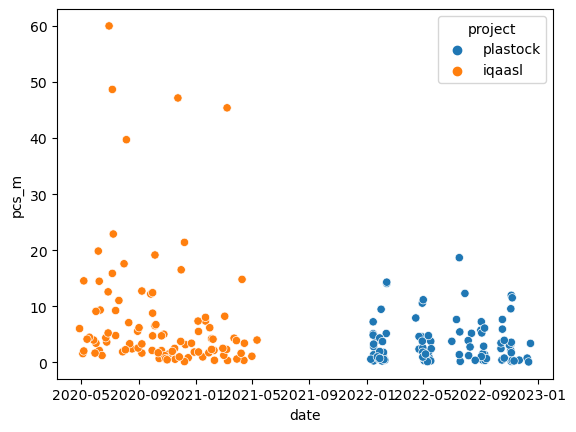

In [14]:
# we need to aggregate by sample
daily_totals = workdata.groupby(["loc_date", "date", "project"], as_index=False).pcs_m.sum()

fig, ax = plt.subplots()

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax, hue="project")

plt.show()

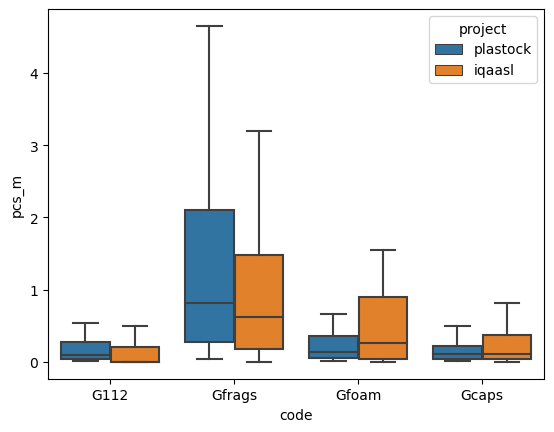

In [15]:
# compare code values
# choose a code
codes = ["G112", "Gcaps", "Gfoam", "Gfrags"]

fig, ax = plt.subplots()

sns.boxplot(data=workdata[workdata.code.isin(codes)], x="code", y="pcs_m", ax=ax, hue="project", showfliers=False)

plt.show()

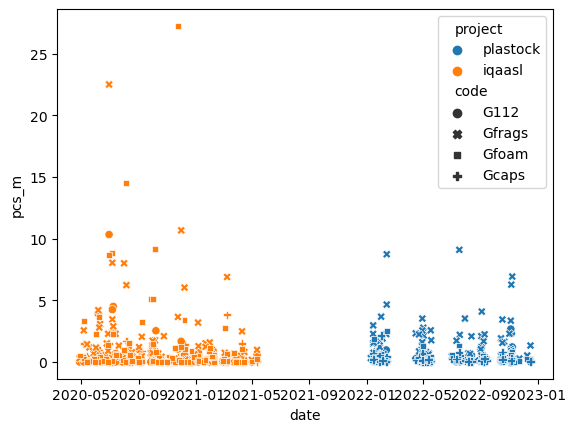

In [16]:
# we need to aggregate by sample
daily_totals = workdata[workdata.code.isin(codes)]

fig, ax = plt.subplots()

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", ax=ax, hue="project", style="code")


plt.show()

In [17]:
summary = daily_totals.groupby(["project", "code"]).pcs_m.describe()
summary.index.names = (None, None)

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]


summary.style.set_table_styles(table_css_styles)